# RETO ATMIRA STOCK PREDICTION

**Authors:** Albert García López, Joan Boronat Ruiz, Pep Martí Mascaro

**Date:** 17 March 2021

**Description:** En este notebook se presenta la solución al reto <a href="https://www.cajamardatalab.com/datathon-cajamar-universityhack-2021/retos/predictivo/">Atmira stock prediction</a> de la UniversityHack 2021. 

Este reto consiste en la predicción de ventas de la eCommerce PCComponentes para los meses de octubre, noviembre y diciembre de 2016 a partir de los datos de los 15 meses anteriores. Como particularidad en este reto contamos con el número de visitas para los meses a predecir. Debido a esto, hemos enfocado el problema desde el punto de vista de una serie temporal y desde el punto de vista de regresión.

- La predicción de la serie temporal nos permite pesar con mayor precisión la estacionalidad de los datos con periodos, como por ejemplo Black Friday o Navidad, con un gran incremento de ventas. El modelo usado en este caso ha sido <a href="https://facebook.github.io/prophet/">Prophet</a>. Para una mejor predicción, hemos creado un modelo para cada producto en el dataset.  


- Para la regresión hemos usado <a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a> que nos ha permitido predecir las ventas a partir de las características de los productos. Para evitar que los periodos con descuentos influencien en exceso la predicción, hemos entrenado el modelo únicamente con los datos de los mismos meses del año anterior.

Finalmente hemos aplicado una técnica de <a href="https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/">blending</a> con los dos anteriores resultados para obtener un resultado final. Para ello hemos usado un regresor lineal. 

<br><br>
### Descripción del dataset

**Fecha** : momento del tiempo en el que se produce el evento.
    
**Id**: número identificador del artículo.
    
**Visitas**: número de veces que ha sido visualizada la ficha de un producto dado para un día concreto. Remarcamos que puede darse el caso en el que las visitas sean inferiores a las compras de ese mismo día, siempre que el producto que se ha comprado estuviera previamente añadido al carrito o se haya añadido desde la opción del recomendador sin pasar por ficha de producto.
    
**Categoría_uno**: categoría de producto nivel uno.
    
**Categoría_dos**: segundo nivel de agrupación para cada producto que precede a la de nivel uno.
    
**Estado**: situación en la que se encuentra el producto. Esta variable toma 3 posibles valores para el dataset Modelar_UH2021:
- Rotura: no hay stock físico disponible para servir en nuestros almacenes.
- Tránsito: no hay stock físico en nuestros almacenes, pero está pendiente de entrega inminente desde proveedor.
- No Rotura: hay stock físico disponible en nuestros almacenes.

Para el dataset Estimar_UH2021 todas las variables aparecen con el estado Tránsito o No Rotura.

**Precio**: indica el precio unitario al que se realiza la transacción. Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.

**Día atípico**: toma los siguientes valores:
- 0: si estamos fuera de fechas con comportamiento atípico.
- 1: si estamos en un periodo con una demanda más alta de lo habitual.
- -1: si estamos en un periodo con una demanda más baja de lo habitual.

**Campaña**: esta variable nos indica para las campañas principales, si el producto estaba en promoción o no en una fecha determinada.

**Antiguedad**: días transcurridos desde la entrada en catálogo de cada producto.

**Unidades vendidas**: variable a predecir. Nos indica las unidades vendidas para cada día y cada artículo.

### Resources

* https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet
* https://towardsdatascience.com/demand-forecasting-using-fb-prophet-e3d1444b9dd8
* https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
* https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/

### Table of contents

1. [Loading Data & Libraries](#loadingLibraries)
    1. [Visualizing the problem](#visualizingProblem)
    2. [Data Description](#dataDescription)
2. [Data Preprocess](#dataPreprocess)
    1. [Removing Duplicates](#removingDuplicates)
    2. [Defining Data Types](#dataTypes)
    3. [Estimate Missing Values](#estimateMissing)
    4. [Filling Missing Values](#fillMissing)
    5. [Normalizing](#normalizing)
    6. [Defining New Features](#newFeatures)
3. [Predictions](#predictions)
    1. [Prophet](#prophet)
        1. [Validation](#prophetVal)
        2. [Test](#prophetTest)
    2. [XGBoost](#xgboost)
        1. [Validation](#xgboostVal)
        2. [Test](#xgboostTest)
    3. [Blending](#blending)
        1. [Validation](#blendingVal)
        2. [Test](#blendingTest)
4. [Next Steps](#nextSteps)

<br><br>

# <a name="loadingLibraries">1. Loading Data & Libraries</a>

In [1]:
import datetime
import pickle

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm

import xgboost as xgb
from fbprophet import Prophet

%matplotlib inline
plt.style.use('./base.mplstyle')

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./dataset/Modelar_UH2021.txt', sep='|')

df['fecha'] = pd.to_datetime(df['fecha'].str.split(' ').str[0], format='%d/%m/%Y')
days_count = (df['fecha'].max() - df['fecha'].min()).days

In [3]:
df_test = pd.read_csv('./dataset/Estimar2.txt', sep='|', low_memory=False)
df_test['fecha'] = pd.to_datetime(df_test['fecha'], format='%Y-%m-%d')

### <a name="visualizingProblem"> 1.1 Visualizing the problem</a>

In [4]:
holidays_train = df[['fecha', 'dia_atipico']]
holidays_test = df_test[['fecha', 'dia_atipico']]
holidays = pd.concat([holidays_train, holidays_test])

holidays.drop_duplicates(inplace=True)
holidays = holidays[holidays['dia_atipico'] != 0]

holidays.loc[holidays['dia_atipico'] == 1, 'holiday'] = 'positive'
holidays.loc[holidays['dia_atipico'] == -1, 'holiday'] = 'negative'

In [5]:
def plot(train, kpi, test=None, holidays=None):

    fig, ax = plt.subplots(figsize=(15,4))

    _ = train.plot(ax=ax, y=kpi, lw=.8)
    labels = [f'Train {kpi}']
    if test is not None:
        labels.append(f'Test {kpi}')
        _ = test.plot(ax=ax, y=kpi, lw=.8)
    
    ax.legend(
        labels,
        ncol=3,
        bbox_to_anchor=(0.5, 1.15),
        prop={'size': 12},
        frameon=False
    )
    
    if holidays is not None:
        for holiday in holidays.to_dict('records'):
            if holiday['dia_atipico'] == 1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='green')
            elif holiday['dia_atipico'] == -1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='red')

    _ = ax.set_xlabel('')

In [6]:
test = df_test.groupby(['fecha']).mean().fillna(0)
train = df.groupby(['fecha']).mean().fillna(0)

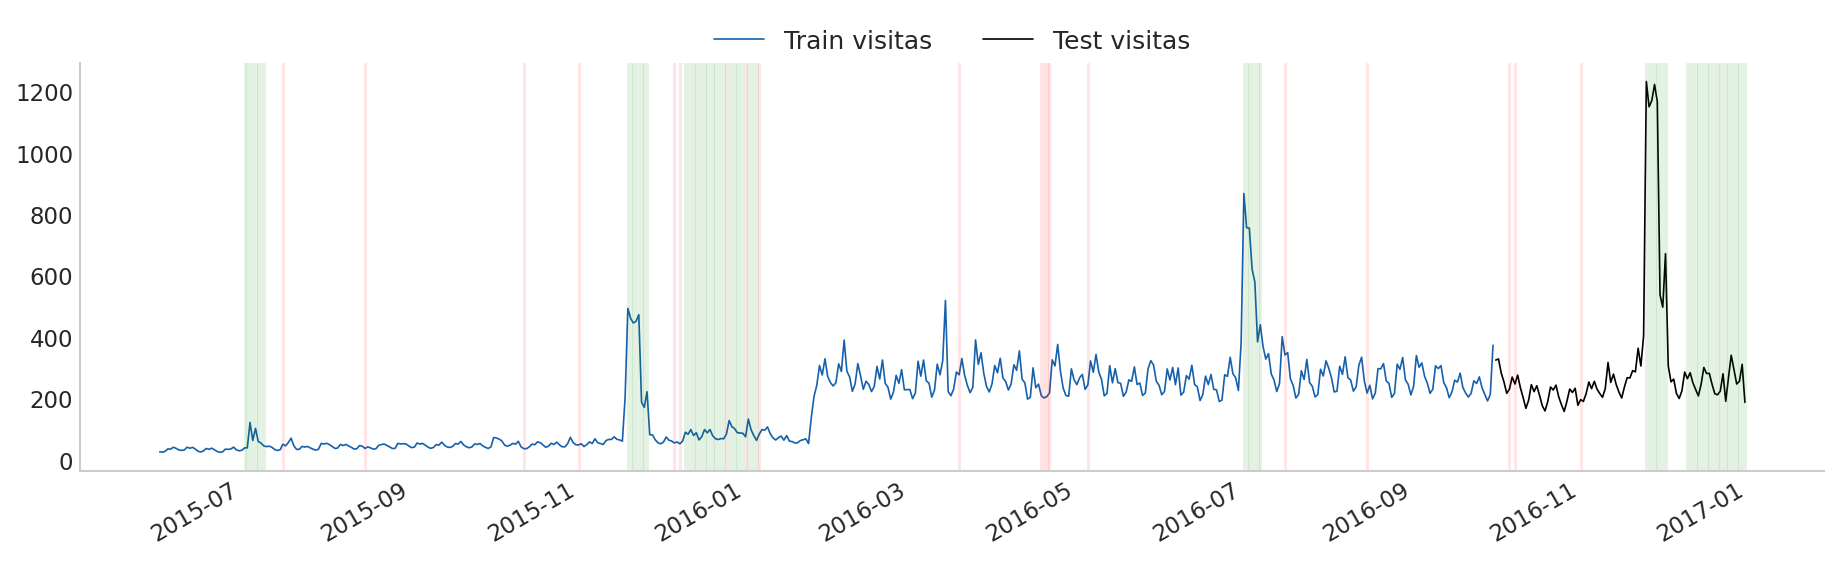

In [7]:
plot(train, 'visitas', test, holidays)

In [8]:
min_test_date = df_test['fecha'].min().strftime('%Y-%m-%d')
max_test_date = df_test['fecha'].max().strftime('%Y-%m-%d')

print(f"We will have to predict the sales from {min_test_date} to {max_test_date}")

We will have to predict the sales from 2016-10-01 to 2016-12-31


### <a name="dataDescription">1.2 Data description</a>

In [9]:
print(f"We have {df.shape[0]} registers with {df.shape[1]} features.")
print(f"The data ranges from {df['fecha'].min()} to {df['fecha'].max()}.")
print(f"We expect to have {days_count} registers per product.")
print(f"There are {df.duplicated().sum()} duplicated registers.")
print(f"There are {df['id'].nunique()} unique products.")
print(f"There are {df['categoria_uno'].nunique()} unique category one.")
print(f"There are {df['categoria_dos'].nunique()} unique category dos.")

We have 4045022 registers with 11 features.
The data ranges from 2015-06-01 00:00:00 to 2016-09-30 00:00:00.
We expect to have 487 registers per product.
There are 2004985 duplicated registers.
There are 4168 unique products.
There are 13 unique category one.
There are 182 unique category dos.


<br><br>
# <a name="dataPreprocess">2. Data Preprocess </a>
### <a name="removingDuplicates">2.1 Removing Duplicates</a>

In [10]:
df = df[~df.duplicated()]

In [11]:
def count_duplicates(df):
    g = df.groupby('id').size()
    return g[g != days_count].shape[0]

count = count_duplicates(df)
print(f"There are {count} products with more registers than days.")

There are 1199 products with more registers than days.


In [12]:
g = df.groupby('id').size()
example_id = g[g != days_count].reset_index()['id'].values[0]
df_example = df[df['id'] == example_id]
df_example[df_example.duplicated(subset=['fecha'], keep=False)].head(5)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
290712,2015-07-06,24306,409,A,46.0,No Rotura,"7,04",1,1,NaN,15
290713,2015-07-06,24306,409,A,46.0,No Rotura,"7,04",1,0,NaN,15
299018,2015-07-07,24306,223,A,46.0,No Rotura,"6,77",1,0,NaN,3
299019,2015-07-07,24306,223,A,46.0,No Rotura,"6,77",1,1,NaN,3
307324,2015-07-08,24306,128,A,46.0,No Rotura,"6,77",1,1,NaN,27


The difference between these duplicated values are the campaña. We will keep drop the rows with campaña 0 if there is a register for the same date and campaña with value 1. 

In [13]:
columns = df.columns.tolist()
columns.remove('campaña')

df.loc[df.duplicated(columns, keep=False), 'campaña'] = '1'
df = df[~df.duplicated()]

In [14]:
count = count_duplicates(df)
print(f"There are still {count} products with more registers than days.")

There are still 3 products with more registers than days.


In [15]:
g = df.groupby('id').size()
example_id = g[g != days_count].reset_index()['id'].sample().values[0]
df_example = df[df['id'] == example_id]
df_example[df_example.duplicated(subset=['fecha'], keep=False)].head(5)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
2932,2015-06-01,260338,98,A,46.0,No Rotura,"24,67",0,0,NaN,6
2944,2015-06-01,260338,98,A,46.0,No Rotura,"24,67",0,0,946.0,6
11238,2015-06-02,260338,88,A,46.0,No Rotura,"24,67",0,0,946.0,3
11250,2015-06-02,260338,88,A,46.0,No Rotura,"24,67",0,0,NaN,3
19544,2015-06-03,260338,83,A,46.0,No Rotura,NaN,0,0,NaN,0


We will remove these registers after filling these missing values as they will become fully duplicated entries


### <a name="dataTypes">2.2 Refining data types</a>

In [16]:
df['precio'] = df['precio'].str.replace(',', '.')
df_test['precio'] = df_test['precio'].str.replace(',', '.')

dtypes = {
    'id': str,
    'categoria_dos': str,
    'precio': float,
    'dia_atipico': str,
    'campaña': str,
    'antiguedad': float
}

df = df.astype(dtypes)

df_test = df_test.replace('-', 0).astype(dtypes)
df_test = df_test.astype(dtypes)

### <a name="estimateMissing">2.3 Estimate missing values</a>

In [17]:
def estimate_antiquity(X_train, X_test):

    y_train = X_train['antiguedad']
    y_test = X_test['antiguedad']

    X_train['id_feature'] = X_train['id']
    X_test['id_feature'] = X_test['id']

    features = ['visitas', 'id_feature', 'precio', 'unidades_vendidas']

    for feature in features:
        scaler = MinMaxScaler()
        X_train[feature] = scaler.fit_transform(X_train[[feature]])
        X_test[feature] = scaler.transform(X_test[[feature]])

    columns = ['categoria_uno', 'categoria_dos']
    X_train = X_train[['id'] + columns + features]
    X_train = pd.get_dummies(X_train, columns=columns)

    X_test = X_test[['id'] + columns + features]
    X_test = pd.get_dummies(X_test, columns=columns)

    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X_train, y_train)

    for col in X_train.columns:
        if col not in X_test:
            X_test[col] = 0

    for col in X_test.columns:
        if col not in X_train:
            X_test.drop(columns=[col], inplace=True)

    return classifier.predict(X_test)

In [18]:
X_train = df[~df.antiguedad.isna()].groupby(['id', 'categoria_uno', 'categoria_dos']).min()
X_train = X_train.reset_index()

X_test = df[df.antiguedad.isna()].groupby(['id', 'categoria_uno', 'categoria_dos']).min()
X_test = X_test.reset_index()

X_test['antiguedad'] = estimate_antiquity(X_train, X_test)

data_by_product = []
antiguedad_estimated = X_test[['id', 'antiguedad']].set_index('id').T.to_dict()

### <a name="fillMissing">2.4 Filling missing values</a>

In [19]:
def fill_missing_values(df, label, antiguedad_estimated):
    
    data_by_product = []
    for product_id in tqdm(set(df['id']), desc=f'Cleaning {label}'):

        aux = df[df['id'] == product_id]
        aux = aux[~aux.duplicated()]
        # Fill the price with the previous most recent value. (Forward fill)
        aux['precio'].ffill(inplace=True)
        aux['antiguedad'].ffill(inplace=True)
        # There are still some missing values. Fill with most recent value. (Back fill)
        aux['precio'].bfill(inplace=True)
        aux['antiguedad'].bfill(inplace=True)
        
        data_by_product.append(aux)

    return pd.concat(data_by_product)

In [20]:
df = fill_missing_values(df, 'train', antiguedad_estimated)
df_test = fill_missing_values(df_test, 'test', antiguedad_estimated)

In [21]:
columns = ['fecha', 'id', 'visitas', 'categoria_uno', 'categoria_dos', 
           'estado', 'precio', 'dia_atipico', 'campaña', 'unidades_vendidas']

df = df[~df.duplicated(subset=columns)]
g = df.groupby('id').size()

count = g[g != days_count].shape[0]
print(f"After some cleaning, we have {count} products with more registers than days.")

After some cleaning, we have 0 products with more registers than days.


### <a name="normalizing">2.5 Normalizing</a>

In [22]:
df['visitas_normalized'] = df['visitas']
df_test['visitas_normalized'] = df_test['visitas']

# See Analysis notebook for the reason why we multiply by 5. 
mask = df['fecha'] < '2016-01-25'
df.loc[mask, 'visitas_normalized'] = df.loc[mask, 'visitas'] * 5

In [23]:
test = df_test.groupby(['fecha']).mean().fillna(0)
train = df.groupby(['fecha']).mean().fillna(0)

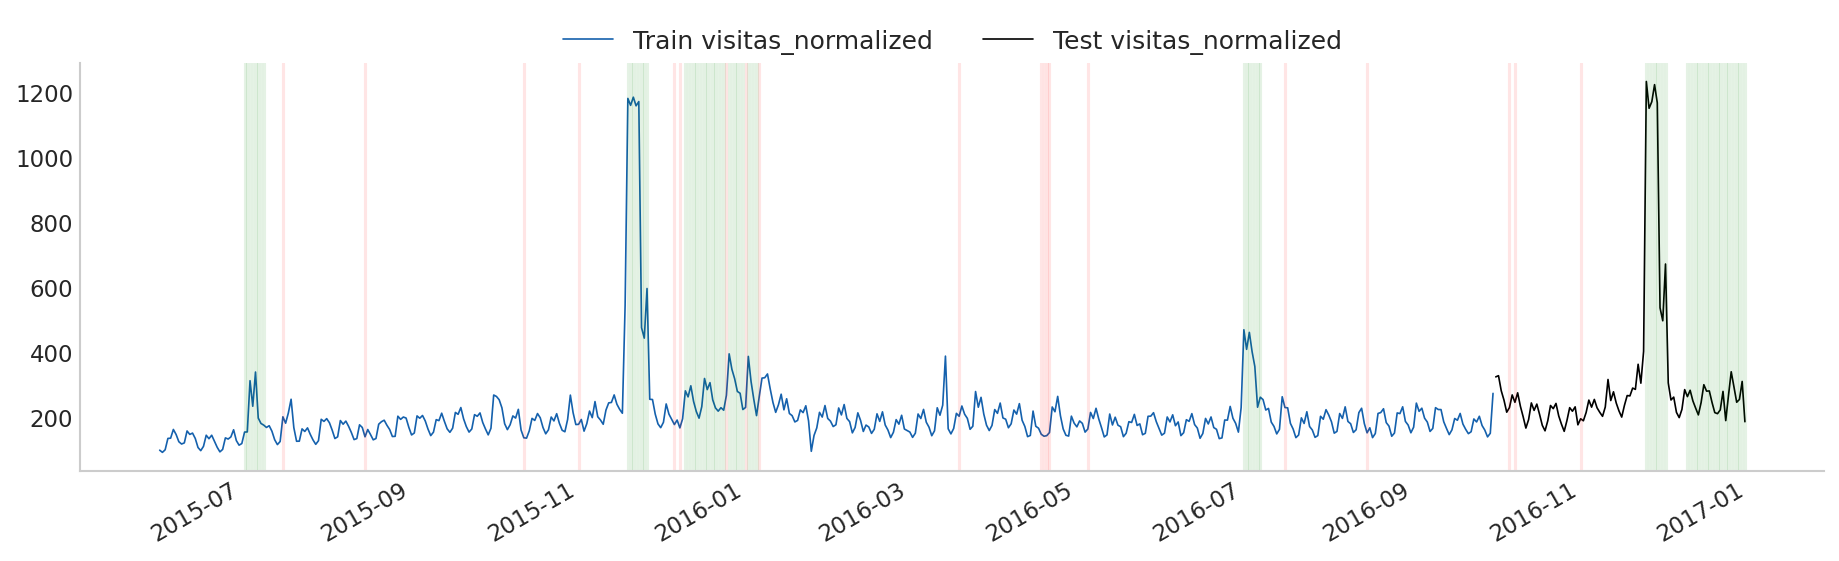

In [24]:
# THIS WILL BE DELETED 
plot(train, 'visitas_normalized', test, holidays)

### <a name="newFeatures">2.6 Defining new features</a>

In [25]:
def get_category_trend(df, df_test, category):
    
    g_train = df.groupby(['fecha', category]).sum().reset_index()
    g_test = df_test.groupby(['fecha', category]).sum().reset_index()

    g = pd.concat([g_train, g_test])
    p = g.pivot(index='fecha', columns=category, values='visitas_normalized')

    g = g.groupby('fecha').sum().reset_index()
    g['overall_trend'] = seasonal_decompose(
        g['visitas_normalized'],
        model='additive',
        period=7
    ).trend
    g['overall_trend'] = g['overall_trend'].ffill().bfill()


    p = p.reset_index().merge(g[['fecha', 'overall_trend']], on='fecha', how='left')

    p = p.set_index('fecha')

    for col in p:
        if p[col].sum() >= 1e6:
            trend = seasonal_decompose(
                p[col],
                model='additive',
                period=7
            ).trend
            p[col] = trend.ffill().bfill()
        else:
            p[col] = p['overall_trend']

    p.drop(columns=['overall_trend'], inplace=True)

    return p.melt(
        ignore_index=False,
        value_name=f'{category}_trend',
        var_name=category
    ).reset_index()

In [26]:
category_trend = get_category_trend(df, df_test, 'categoria_uno')

df.drop(columns=['categoria_uno_trend'], errors='ignore', inplace=True)
df_test.drop(columns=['categoria_uno_trend'], errors='ignore', inplace=True)

df = df.merge(category_trend, on=['fecha', 'categoria_uno'], how='left')
df_test = df_test.merge(category_trend, on=['fecha', 'categoria_uno'], how='left')

In [27]:
def add_time_segments(df):
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['week_number'] = df['fecha'].dt.isocalendar().week
    df['day_of_week'] = df['fecha'].dt.dayofweek
    return df

df = add_time_segments(df)
df_test = add_time_segments(df_test)

<br><br>
# <a name="Predictions">3. Predictions</a>

In [28]:
class BaseModel:
    
    def __init__(self, df_train, df_test, holidays, validation=False):
        
        self.y_train = df_train['unidades_vendidas'].copy()        
        if validation:
            self.y_test = df_test['unidades_vendidas'].copy()
            
        features = df_train.columns.tolist()
        features.remove('unidades_vendidas')
        self.train = df_train[features].copy()
        self.test = df_test[features].copy()
        self.holidays = holidays
        self.validation = validation

    def score(self):
        mse = mean_squared_error(self.y_test, self.y_pred)
        rmse = np.sqrt(mse)
        rrmse = rmse / self.y_train.mean()
        cf = (self.y_test <= self.y_pred).sum() / len(self.y_pred)
        score = (0.7 * rrmse) + (0.3 * (1 - cf))
        return score
    
    def plot(self):
        self.train['y'] = self.y_train
        g = self.train.groupby(['fecha']).sum()
        
        self.test['y_pred'] = self.y_pred
        if self.validation:
            self.test['y'] = self.y_test
        g_pred = self.test.groupby(['fecha']).sum()

        fig, ax = plt.subplots(figsize=(15,4))
        _ = g.plot(ax=ax, y='y', lw=.8)
        _ = g_pred.plot(ax=ax, y='y_pred', lw=.8)
        
        if self.validation:
            _ = g_pred.plot(ax=ax, y='y', lw=.8, color='C0')

        ax.legend(
            ['Sales', 'Prediction'],
            ncol=3,
            bbox_to_anchor=(0.8, 1.15),
            prop={'size': 12},
            frameon=False
        )

        for holiday in self.holidays.to_dict('records'):
            if holiday['dia_atipico'] == 1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='green')
            elif holiday['dia_atipico'] == -1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='red')
        _ = ax.set_xlabel('')

        if self.validation:
            _ = ax.set_title('Score: {:.2f}'.format(self.score()))
            
    def scatterplot_distplot(self):
        
        assert self.validation, "This is only available for validation."        
        self.test['y_pred'] = self.y_pred
        self.test['y'] = self.y_test
        g_pred = self.test.groupby(['fecha']).sum()
        
        p1 = sns.jointplot(x=g_pred['y'], y=g_pred['y_pred'], kind="reg")

        plt.figure(figsize=(15,4))
        sns.distplot(g_pred['y'], hist=True, kde=False)
        sns.distplot(g_pred['y_pred'], hist=True, kde=False)
        plt.legend(labels=['True Values', 'Predicted Values'])
        plt.xlim(0,)

### <a name="prophet">3.1 Prophet</a>

In [29]:
class MyProphet(BaseModel):
    
    def __init__(self, df_train, df_test, holidays, regressors, validation=False):
        
        intersection = set(df_train['fecha']).intersection(set(df_test['fecha']))
        assert intersection == set(), "Train and test not well defined"

        df_train['ds'] = df_train['fecha']
        df_train['y'] = df_train['unidades_vendidas']
        
        df_test['ds'] = df_test['fecha']
        df_test['y'] = df_test['unidades_vendidas'] if validation else np.nan
        
        super().__init__(
            df_train,
            df_test,
            holidays,
            validation
        )
        
        self.predictions = {}
        self.regressors = regressors
        self.features = ['ds', 'y'] + regressors
        self.holidays['ds'] = self.holidays['fecha']
    
    def fit_product(self, product_id):
        train_prod = self.train[self.train['id'] == product_id] 
        prophet_col_names = {'fecha': 'ds', 'unidades_vendidas': 'y'}
        
        model = Prophet(
            holidays=self.holidays,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            uncertainty_samples = False
        )
        
        for feature in self.regressors: 
            model.add_regressor(feature, standardize=True)
            
        model.fit(train_prod)
        return model

    def fit_and_predict(self):
        for product_id in tqdm(set(self.test['id']), desc='Fit & Predict'):    
            model = self.fit_product(product_id)
            
            test_prod = self.test[self.test['id'] == product_id]
            y_pred_prod = model.predict(test_prod)
            y_pred_prod['id'] = product_id
            y_pred_prod.loc[y_pred_prod['yhat'] < 0, 'yhat'] = 0
            
            self.predictions[product_id] = y_pred_prod
        
        predictions = pd.concat(self.predictions.values())
        m = self.test.merge(predictions, on=['ds', 'id'], how='left')
        self.y_pred = m['yhat']

### <a name="prophetVal">3.1.1 Prophet > Validation</a>

In [30]:
df_aux = df.copy()
df_test_aux = df_test.copy()

In [31]:
X_train = df_aux.loc[df_aux["fecha"] < "2016-06-01"].copy().reset_index()
X_test  = df_aux.loc[df_aux["fecha"] >= "2016-06-01"].copy().reset_index()

# subset = X_test['id'].drop_duplicates().sample(100)
# X_train = X_train[X_train['id'].isin(subset)].reset_index()
# X_test = X_test[X_test['id'].isin(subset)].reset_index()

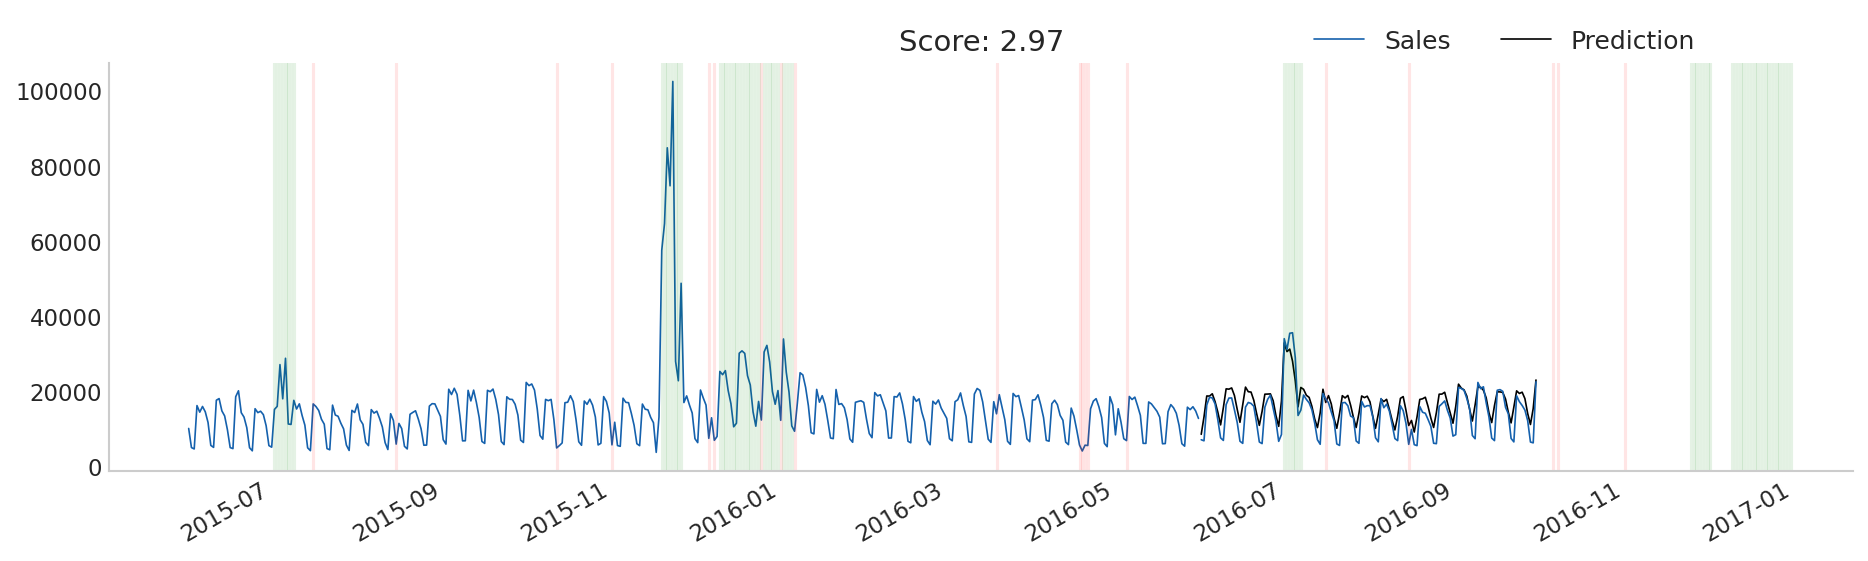

In [32]:
my_prophet = MyProphet(
    X_train,
    X_test,
    holidays,
    regressors=['visitas_normalized', 'categoria_uno_trend'],
    validation=True
)

my_prophet.fit_and_predict()
my_prophet.plot()

/Users/joanboronat/.virtualenvs/ds/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


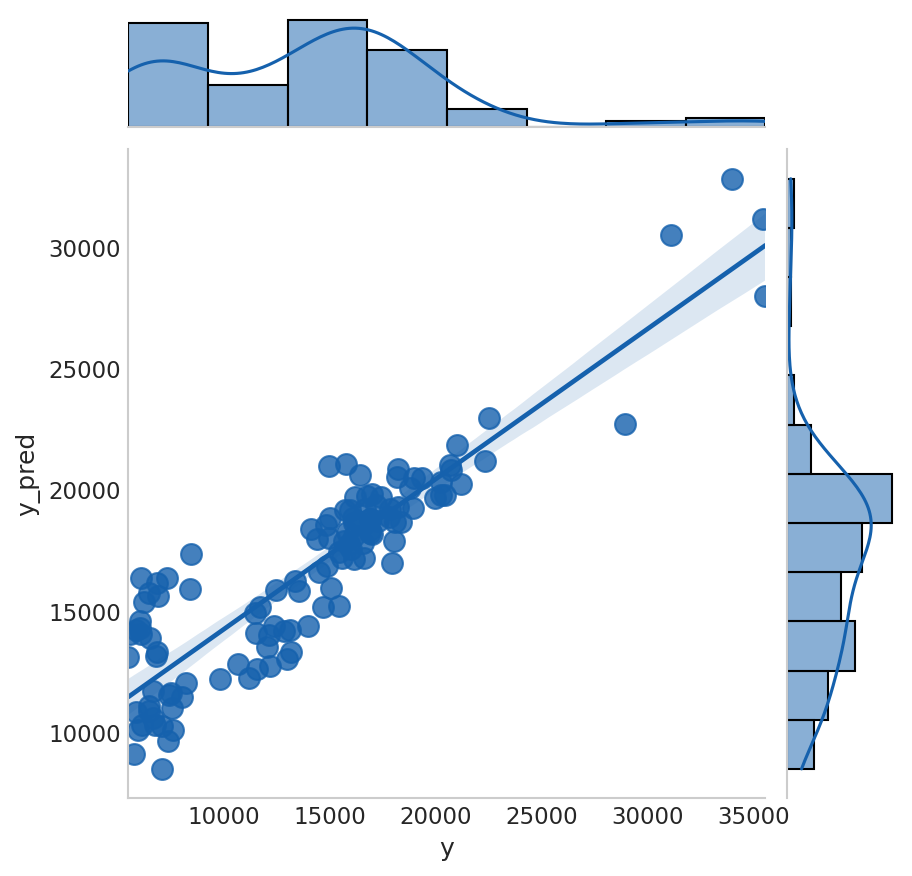

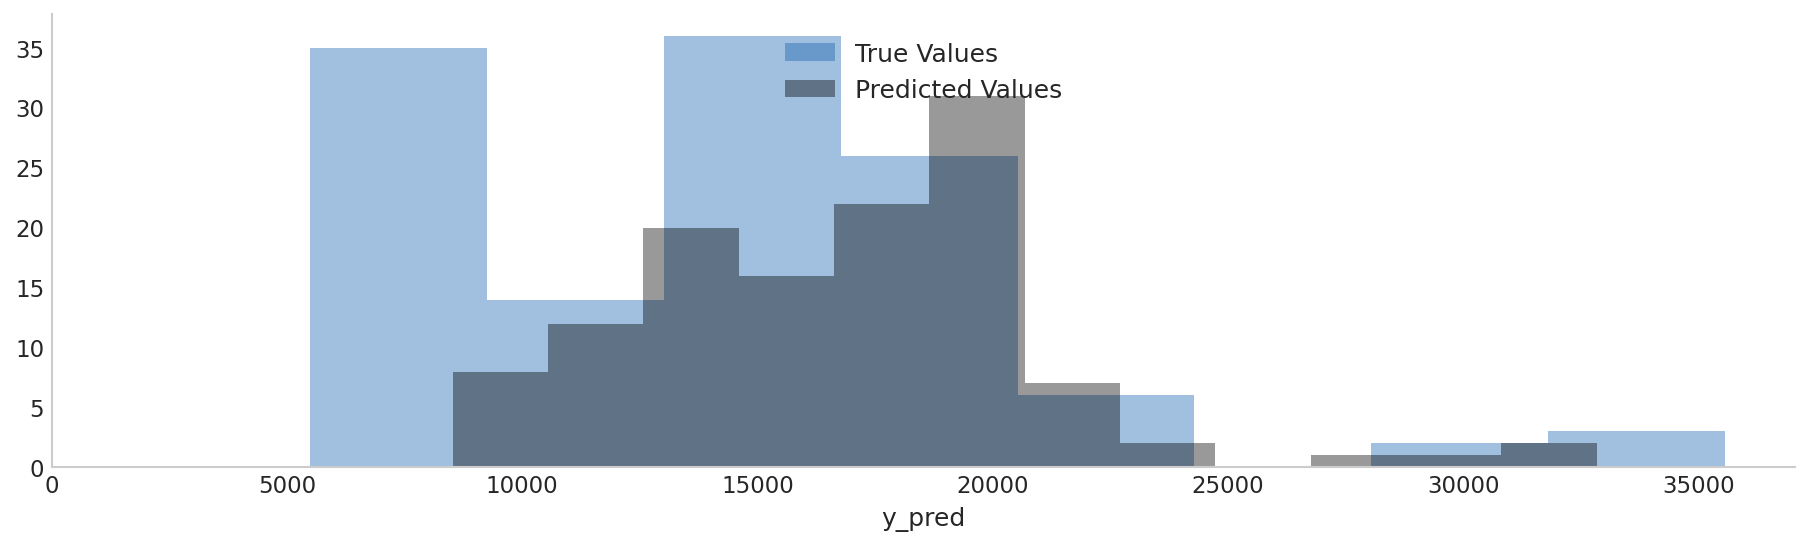

In [33]:
my_prophet.scatterplot_distplot()

### <a name="prophetTest">3.1.2 Prophet > Test

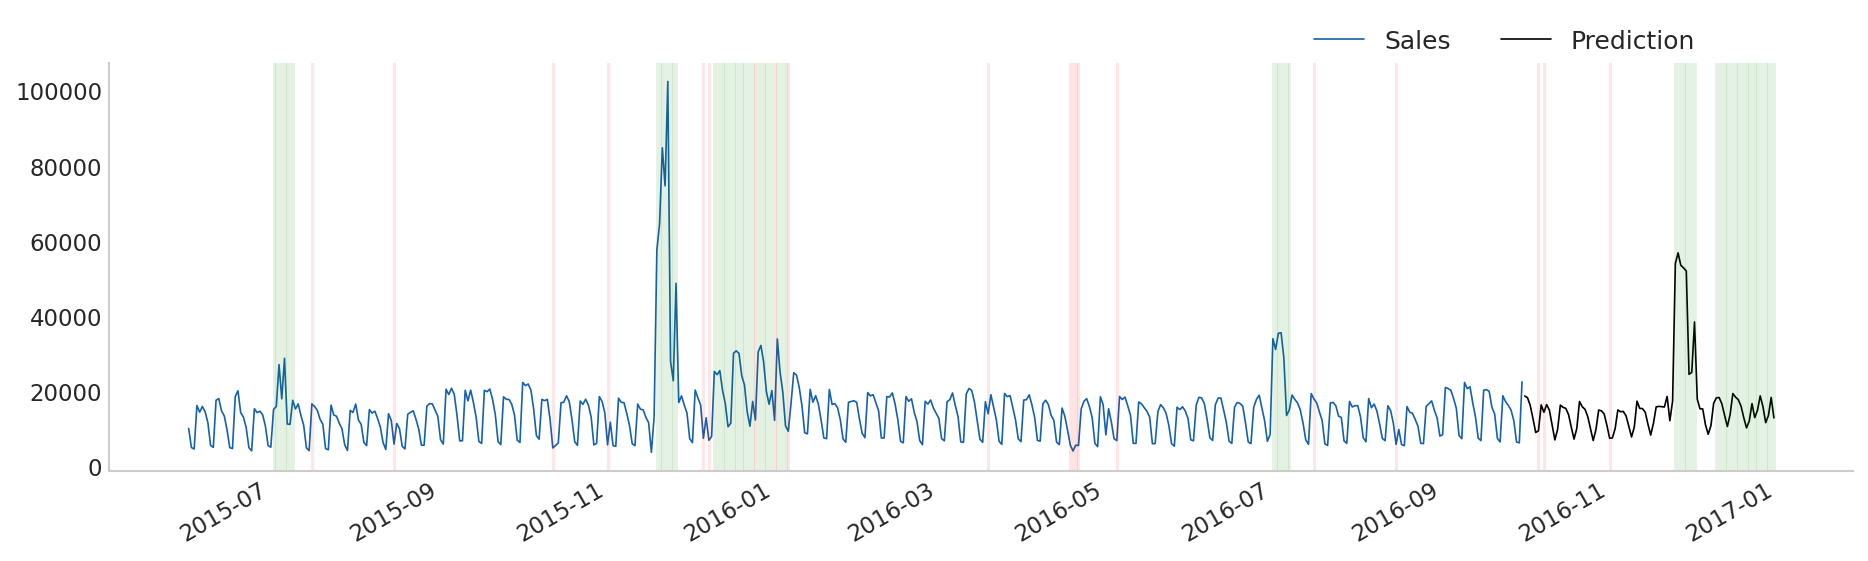

In [34]:
my_prophet_test = MyProphet(
    df_aux,
    df_test_aux,
    holidays,
    regressors=['visitas_normalized', 'categoria_uno_trend']
)

my_prophet_test.fit_and_predict()
my_prophet_test.plot()

### <a name="xgboost">3.2 XGBoost</a>

In [35]:
class MyXGBoost(BaseModel):
    
    def __init__(self, df_train, df_test, numerical, categorical, holidays, validation=False):
        
        intersection = set(df_train['fecha']).intersection(set(df_test['fecha']))
        assert intersection == set(), "Train and test not well defined"
        
        self.numerical = numerical
        self.categorical = categorical
        self.features = numerical + categorical
        self.train_index = df_train[['fecha', 'id']].copy()
        self.test_index = df_test[['fecha', 'id']].copy()
        
        super().__init__(
            df_train[self.features + ['unidades_vendidas']],
            df_test,
            holidays,
            validation
        )
    
    def standarize(self):
        for feature in self.numerical:
            scaler = MinMaxScaler()
            self.train[feature] = scaler.fit_transform(self.train[[feature]])
            self.test[feature] = scaler.transform(self.test[[feature]])
            
    def encode(self):
        for feature in self.categorical:
            dummies = pd.get_dummies(self.train[feature], prefix=feature)
            self.train = pd.concat([self.train, dummies], axis=1)
            self.train.drop(columns=[feature], inplace=True)

            dummies = pd.get_dummies(self.test[feature], prefix=feature)
            self.test = pd.concat([self.test, dummies], axis=1)
            self.test.drop(columns=[feature], inplace=True)

        for col in self.test:
            if col not in self.train:
                self.test.drop(columns=[col], inplace=True)

        for col in self.train:
            if col not in self.test:
                self.train.drop(columns=[col], inplace=True)
        
    def fit(self):
        self.standarize()
        self.encode()
        
        self.model = xgb.XGBRegressor(
            objective='reg:squarederror',
            colsample_bytree = 0.3,
            learning_rate = 0.1,
            max_depth = 5,
            alpha = 10,
            n_estimators = 200
        )
        
        _ = self.model.fit(self.train,self.y_train)

    
    def predict(self):
        self.y_pred = self.model.predict(self.test)
        self.y_pred[self.y_pred < 0] = 0
        self.test[['fecha', 'id']] = self.test_index
        self.train[['fecha', 'id']] = self.train_index

### <a name="xgboostVal">3.2.1 XGBoost > Validation</a>

In [36]:
df_aux = df.copy()

X_train = df_aux.loc[df_aux["fecha"] < "2015-11-01"].copy()
X_train['id'] = X_train['id'].astype(int)

X_test  = df_aux.loc[df_aux["fecha"] >= "2016-06-01"].copy()
X_test['id'] = X_test['id'].astype(int)

In [37]:
numerical = ['id', 'visitas_normalized', 'precio', 'antiguedad', 'categoria_uno_trend']
categorical = ['categoria_uno', 'dia_atipico', 'campaña', 'day_of_week', 'month', 'week_number']

In [38]:
my_xgboost = MyXGBoost(
    X_train,
    X_test,
    numerical,
    categorical,
    holidays,
    validation=True
)

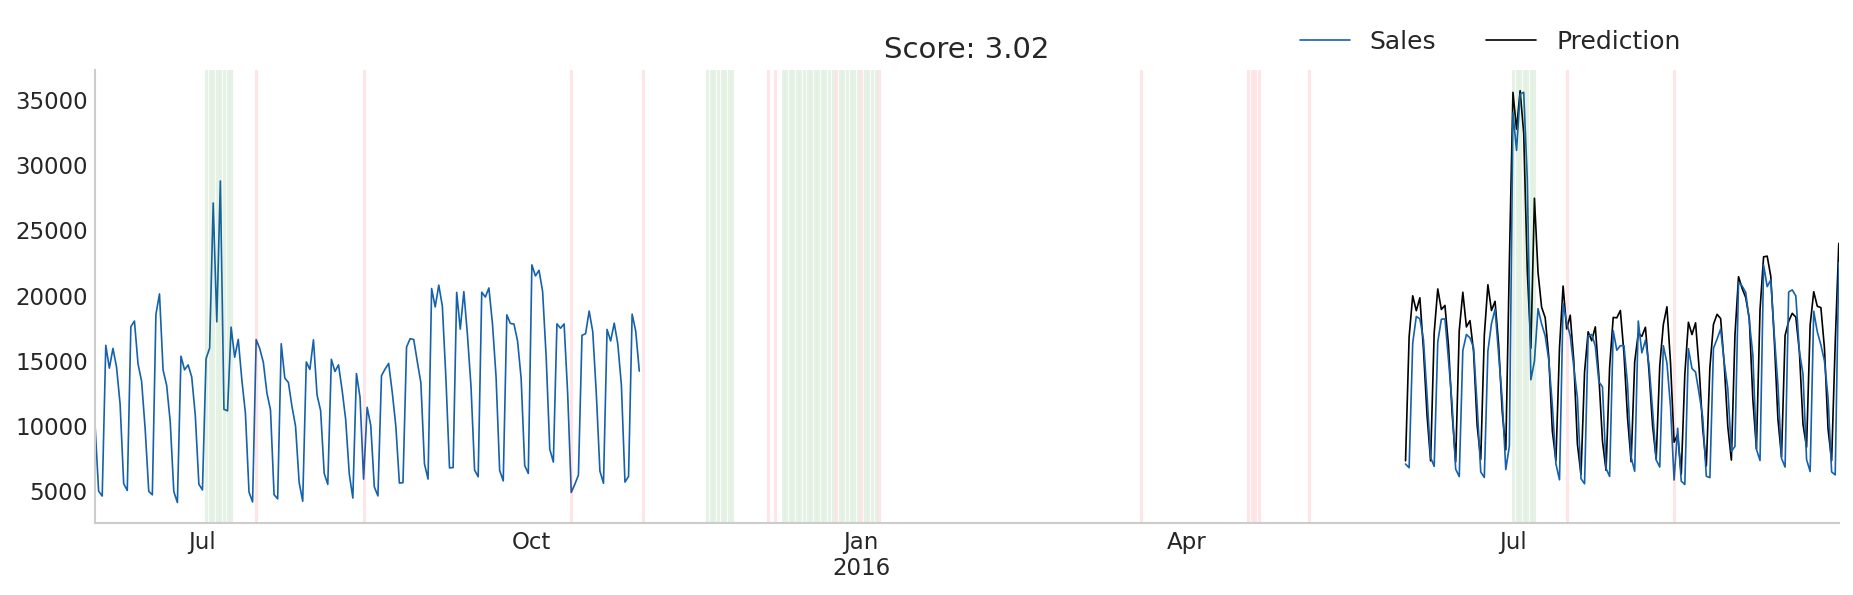

In [39]:
my_xgboost.fit()
my_xgboost.predict()
my_xgboost.plot()

/Users/joanboronat/.virtualenvs/ds/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


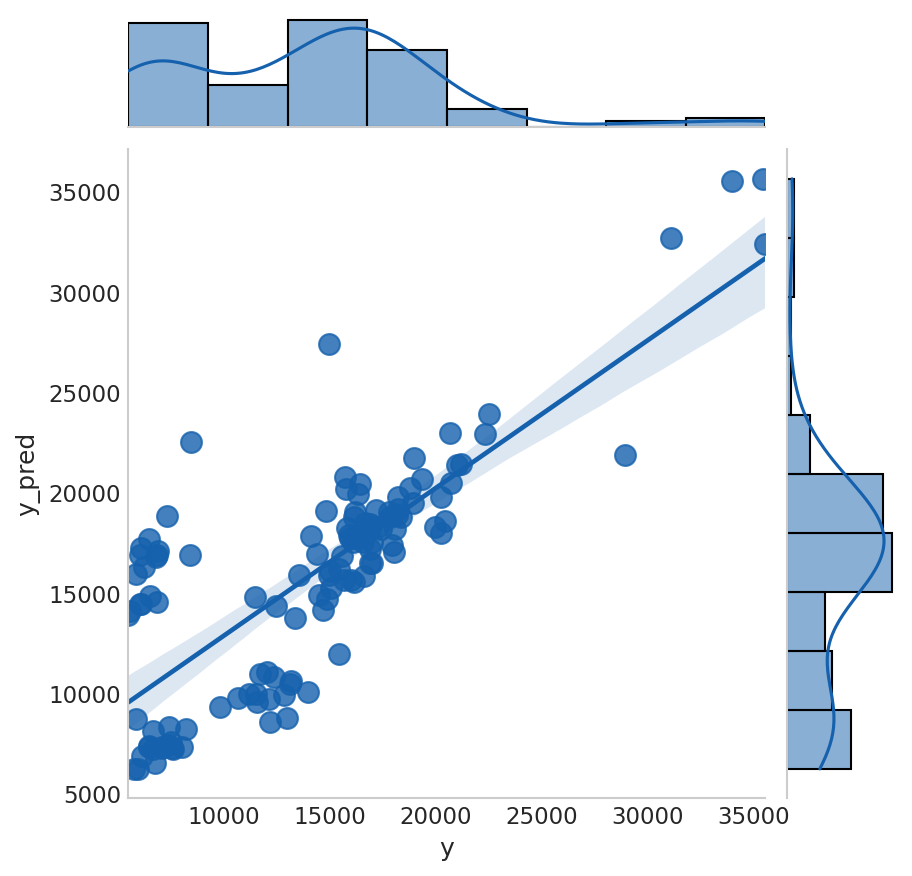

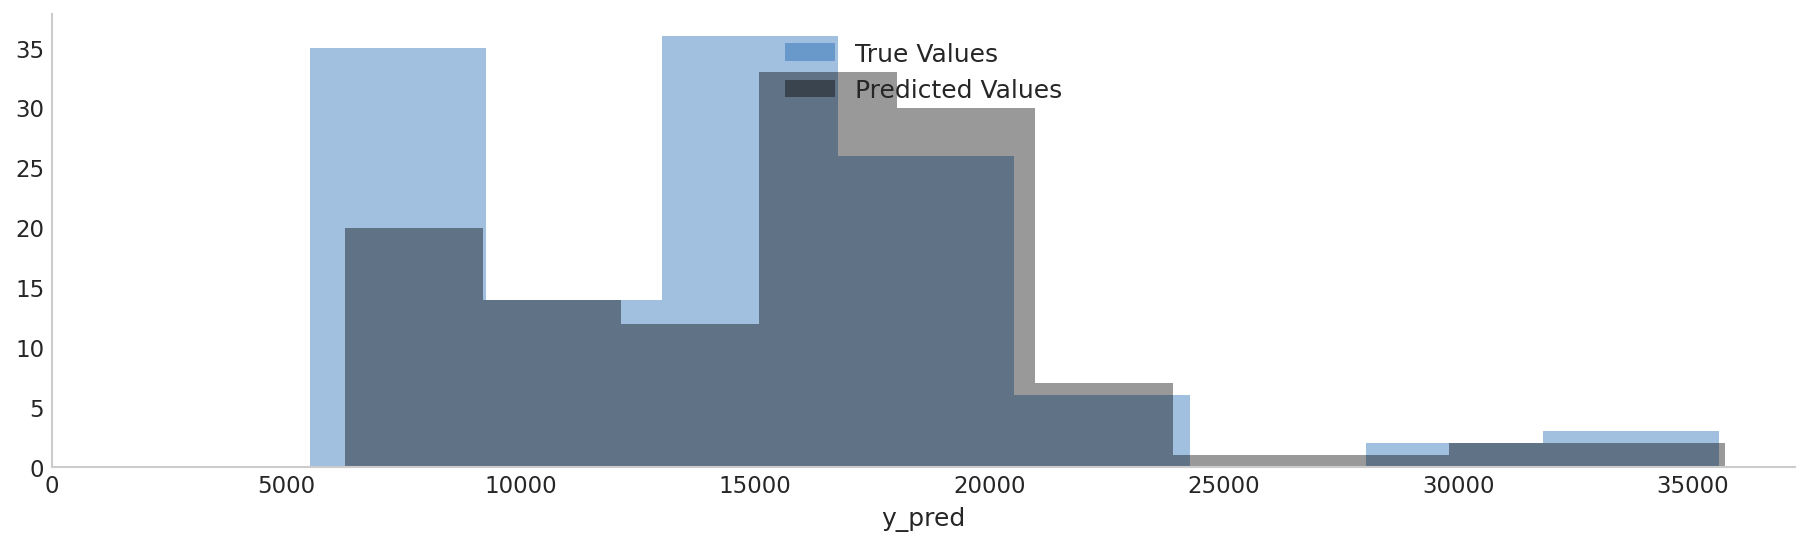

In [40]:
my_xgboost.scatterplot_distplot()

### <a name="xgboostTest">3.2.2 XGBoost > Test</a>

In [41]:
df_aux = df.copy()
df_test_aux = df_test.copy()

X_train = df_aux.loc[
    (df_aux["fecha"] < "2016-01-01") &
    (df_aux["fecha"] >= "2015-10-01")
].copy()

X_train['id'] = X_train['id'].astype(int)

X_test = df_test_aux.copy()
X_test['id'] = X_test['id'].astype(int)

In [42]:
my_xgboost_test = MyXGBoost(
    X_train,
    X_test,
    numerical,
    categorical,
    holidays
)

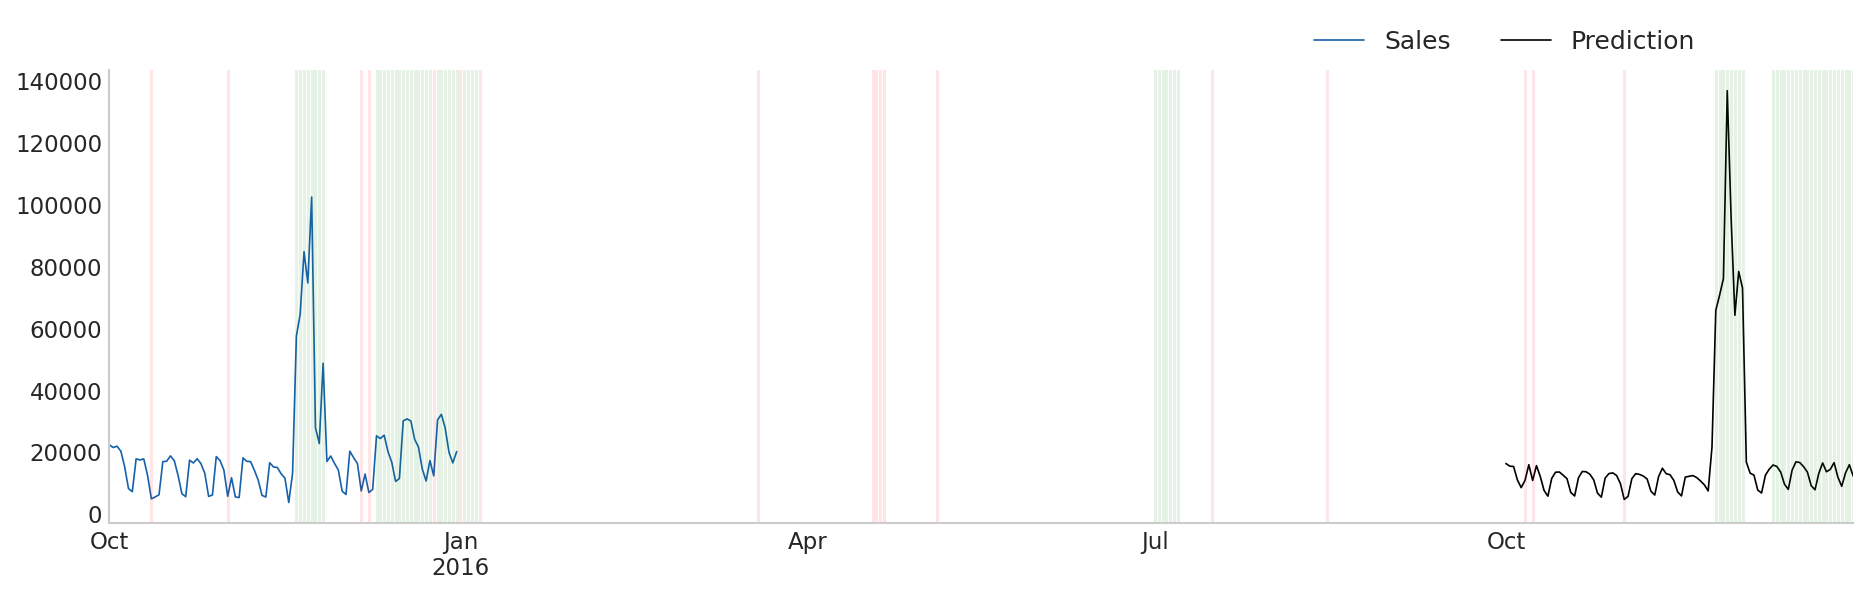

In [43]:
my_xgboost_test.fit()
my_xgboost_test.predict()
my_xgboost_test.plot()

### <a name="blending">3.3 Blending</a>

In [44]:
class Blender(BaseModel):
    
    def __init__(self, df_train, df_test, numerical, categorical, holidays, validation=False):
                
        self.numerical = numerical
        self.categorical = categorical
        
        self.features = numerical + categorical
        train_aux = df_train[['fecha', 'id', 'unidades_vendidas'] + self.features]
        if validation:
            test_aux = df_test[['fecha', 'id', 'unidades_vendidas'] + self.features]
        else:
            test_aux = df_test[['fecha', 'id'] + self.features]

        super().__init__(train_aux, test_aux, holidays, validation)
        
    def standarize(self):
        for feature in self.numerical:
            scaler = MinMaxScaler()
            self.train[feature] = scaler.fit_transform(self.train[[feature]])
            self.test[feature] = scaler.transform(self.test[[feature]])

    def encode(self):
        for feature in self.categorical:
            dummies = pd.get_dummies(self.train[feature], prefix=feature)
            self.train = pd.concat([self.train, dummies], axis=1)
            self.train.drop(columns=[feature], inplace=True)

            dummies = pd.get_dummies(self.test[feature], prefix=feature)
            self.test = pd.concat([self.test, dummies], axis=1)
            self.test.drop(columns=[feature], inplace=True)

        for col in self.test:
            if col not in self.train:
                self.test.drop(columns=[col], inplace=True)

        for col in self.train:
            if col not in self.test:
                self.train.drop(columns=[col], inplace=True)
        
    def fit(self):
        self.standarize()
        self.encode()
        
        self.model = LinearRegression()
        cols = self.train.columns.tolist()
        cols.remove('fecha')
        _ = self.model.fit(self.train[cols], self.y_train)
        
    def predict(self):
        cols = self.test.columns.tolist()
        cols.remove('fecha')
        self.y_pred = self.model.predict(self.test[cols])
        self.y_pred = np.ceil(self.y_pred).astype(int)
        self.y_pred[self.y_pred < 0] = 0
        
    def save_predictions(self, filename=None):
        
        if filename is None:
            filename = datetime.datetime.now().isoformat() + '.txt'

        solution = self.test.copy()
        solution['unidades_vendidas'] = self.y_pred.copy()
        
        assert solution.shape[0] == 212841, 'Carefull! Something went wrong!'
        
        solution.rename(columns={'fecha': 'FECHA', 'id': 'ID', 'unidades_vendidas': 'UNIDADES'}, inplace=True)
        solution['FECHA'] = solution['FECHA'].dt.strftime('%d/%m/%Y')
        headers = ['FECHA', 'ID', 'UNIDADES']
        solution[headers].to_csv(filename, encoding='UTF-8', sep='|', index=False)

### <a name="blendingVal">3.3.1 Blending > Validation</a>

In [45]:
def merge_models_predictions(models, validation=False):
    merged = None
    for name, model in models:
        aux = model.test.copy()[['id', 'fecha']]
        aux[name] = model.y_pred
        aux['id'] = aux['id'].astype(str)
        
        if merged is None:
            if validation:
                aux['unidades_vendidas'] = model.y_test
            merged = aux.copy()
        else:
            merged = merged.merge(aux, on=['id', 'fecha'])
    
    return merged

In [46]:
df_aux = merge_models_predictions(
    [('xgboost', my_xgboost), ('prophet', my_prophet)],
    validation=True
)

df_test_aux = merge_models_predictions(
    [('xgboost', my_xgboost_test), ('prophet', my_prophet_test)],
)

In [47]:
df_aux = df_aux.merge(df, on=['id', 'fecha'], suffixes=('', '_org'))
df_test_aux = df_test_aux.merge(df_test, on=['id', 'fecha'], suffixes=('', '_org'))

In [48]:
X_train = df_aux.loc[df_aux["fecha"] < "2016-09-01"].copy().reset_index()
X_test = df_aux.loc[df_aux["fecha"] >= "2016-09-01"].copy().reset_index()

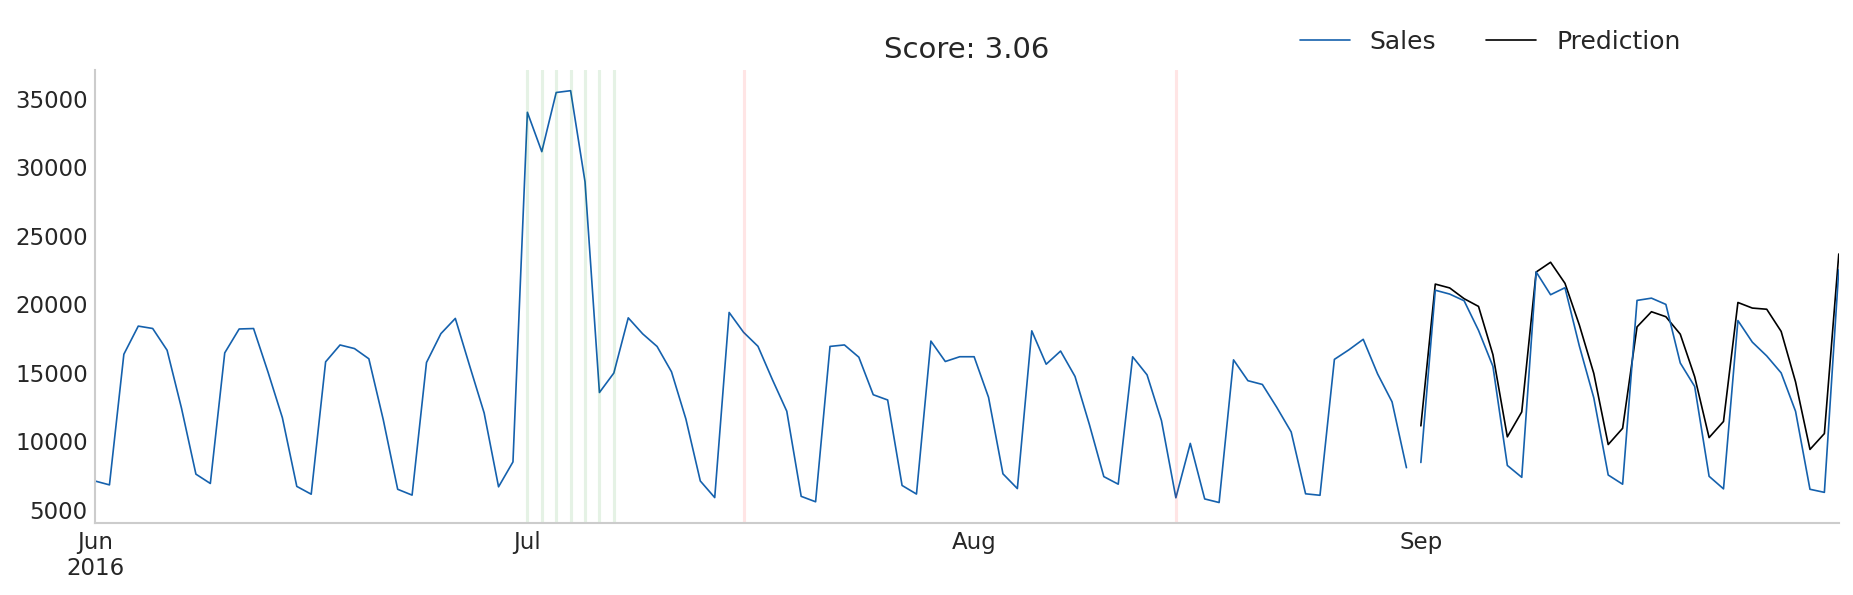

In [54]:
blender = Blender(
    X_train,
    X_test,
    ['xgboost', 'prophet'],
    ['day_of_week'], 
    holidays,
    validation=True
)

blender.fit()
blender.predict()
blender.plot()

### <a name="blendingTest">3.3.3 Blending > Test</a>

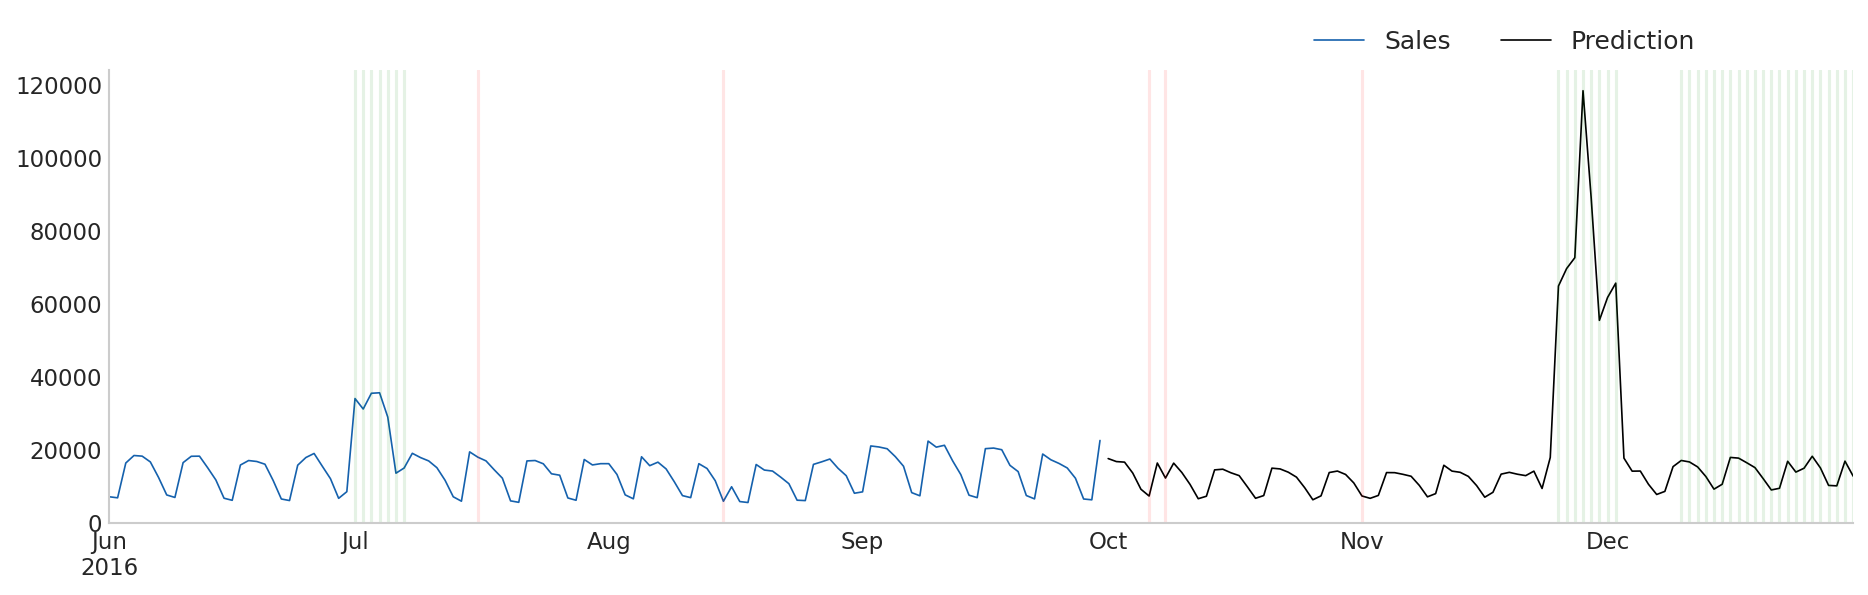

In [50]:
blender = Blender(
    df_aux, 
    df_test_aux, 
    ['xgboost', 'prophet'],
    ['day_of_week'],
    holidays
)

blender.fit()
blender.predict()
blender.plot()

In [51]:
blender.save_predictions()

<br><br>
# <a name="nextSteps">4. Next steps</a>

En este notebook hemos mostrado nuestro proceso de resolución del problema de Stock Prediction. Entendemos esta solución como la base necesaria para poder seguir iterando sobre dicho proceso. 

Para facilitarnos la creación de nuevos modelos hemos usado una clase padre (BaseModel) que tiene los métodos básicos para medir y mostrar la predicción de los distintos modelos. A partir de aquí podemos crear los distintos modelos que heredarán los métodos de BaseModel de modo que podemos seguir probando modelos con facilidad. 

Actualmente para el análisis de la serie temporal estamos usando el modelo Prophet cuya sencillez nos ha permitido integrarlo rápidamente, pero también hemos encontrado algunas limitaciones. Por este motivo vamos a probar otros modelos más versátiles como el ARIMA o el <a href="https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795">seq2seq</a>. De igual modo también probaremos otros modelos para añadir al blending o para sustituir a los actuales. 

Aparte de probar otros modelos, también queremos mejorar los existentes usando técnicas de normalización como el <a href="https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203">Box-Cox</a> sobre nuestra variable objetivo para mejorar la distribución de los errores que actualmente se focaliza sobretodo en los productos con pocas ventas. También vamos a explorar la creación de una loss function personalizada para que tenga en cuenta que la rotura de stock penaliza más que el excedente. 

Seguir explorando la creación de variables a partir de las variables actuales, así como trabajar en la  mejora de la evaluación de nuestros modelos, tanto en la adición de nuevas métricas como MAPE y MAE como en la mejora de los gráficos utilizados.

Finalmente tenemos el modelo de blending. Dicho modelo tiene como objetivo entender en qué casos cada uno de los modelos de nivel 0 predice mejor las unidades vendidas. El modelo que usamos actualmente es un regresor lineal, pero vamos a explorar posibles alternativas como un random forest. 

Como resumen de los siguientes pasos:
1. Métodos de normalización. Mejorar la distribución de las features. 
2. Feature engineering. Explorar la creación de nuevas categorias o agregaciones de las existentes en función de las características de los productos
3. Nuevas métricas de evaluación y visualización de los errores. 
4. Custom Loss function. Aumentar el peso del error en caso de rotura de stock. 
5. Explorar nuevos modelos para el posterior stacking. En concreto el seq2seq y el ARIMA. 
6. Probar otros modelos para el blending p.ej. Random Forest. 